In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
import time
from pathlib import Path
import csv
import re
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trainPath="/content/drive/MyDrive/Capstone /lsa/mediapipe/train15"
valPath="/content/drive/MyDrive/Capstone /lsa/mediapipe/val15"
testPath="/content/drive/MyDrive/Capstone /lsa/mediapipe/test15"


## EDA

In [56]:
#count number of files
counts=[]
label=[]

for file in os.listdir(trainPath):
  filepath= os.path.join(trainPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))




{'appear': 256,
 'bitter': 256,
 'born': 256,
 'Argentina': 256,
 'away': 256,
 'accept': 256,
 'birthday': 256,
 'bathe': 256,
 'barbecue': 256,
 'buy': 256,
 'bright': 256,
 'catch': 256,
 'candy': 256,
 'breakfast': 256,
 'call': 256}

In [ ]:
counts=[]
label=[]

for file in os.listdir(valPath):
  filepath= os.path.join(valPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))

{'Argentina': 64,
 'bitter': 64,
 'away': 64,
 'barbecue': 64,
 'bathe': 64,
 'born': 64,
 'birthday': 64,
 'accept': 64,
 'appear': 64,
 'breakfast': 64,
 'buy': 64,
 'catch': 64,
 'candy': 64,
 'call': 64,
 'bright': 64}

In [ ]:
counts=[]
label=[]

for file in os.listdir(testPath):
  filepath= os.path.join(testPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))

{'catch': 10,
 'breakfast': 10,
 'buy': 10,
 'call': 10,
 'candy': 10,
 'bright': 10,
 'barbecue': 10,
 'bitter': 10,
 'birthday': 10,
 'Argentina': 10,
 'born': 10,
 'bathe': 10,
 'appear': 10,
 'away': 10,
 'accept': 10}

## Split Data

In [ ]:
#split data
import os
import shutil
import random

source_folder = trainPath  # Path to the source folder
destination_folder = valPath  # Path to the destination folder

# Iterate through each subfolder in the source folder
for root, dirs, files in os.walk(source_folder):
    for directory in dirs:
        files_to_move = os.listdir(root+"/"+ directory)
        random.shuffle(files_to_move)  # Shuffle the files

        # Calculate 20% of the files to move
        num_files_to_move = int(len(files_to_move) * 0.20)

        # Select 20% of the files
        files_to_move = files_to_move[:num_files_to_move]

        # Create the destination subfolder if it doesn't exist
        destination_subfolder =destination_folder+"/"+directory
        os.makedirs(destination_subfolder, exist_ok=True)

        # Move the selected files to the destination subfolder
        for file in files_to_move:
            source_file = os.path.join(root, directory, file)
            destination_file = os.path.join(destination_subfolder, file)
            shutil.move(source_file, destination_file)
            print(destination_file)

/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01388abe.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_65029be.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01384bde.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01384aabcf.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01387aabe.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01398aac.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01388a.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01387cf.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_65029bcf.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01398aacd.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01388aade.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01387adef.mp4
/content/drive/MyDrive/Capstone /minibatch/val/africa/africa_01388abc.mp4
/content/drive/MyDrive/Capstone /min

In [10]:
#prepare label

glossLst=[]
for file in os.listdir(trainPath):
  glossLst.append(file)
glossLst= sorted(glossLst)
glossLst

['Argentina',
 'accept',
 'appear',
 'away',
 'barbecue',
 'bathe',
 'birthday',
 'bitter',
 'born',
 'breakfast',
 'bright',
 'buy',
 'call',
 'candy',
 'catch']

In [11]:
import tensorflow as tf

#perform one-hot encoding in glosses
idxarray=tf.keras.utils.to_categorical([i for i in range(len(glossLst))], num_classes=15)
class_ids=dict(zip(glossLst, idxarray))

## Frame Generator

In [ ]:
from tensorflow.python.module.module import valid_identifier
#check the number of videos for training, validation and test data

train_vid=[]
for file in os.listdir(trainPath):
  filepath= trainPath+"/"+file
  for v in os.listdir(filepath):
    if v.endswith("mp4"):
      train_vid.append(v)
print(f'Total of {len(train_vid)} train videos')

val_vid=[]
for file in os.listdir(valPath):
  filepath= valPath+"/"+file
  for v in os.listdir(filepath):
    if v.endswith("mp4"):
      val_vid.append(v)
print(f'Total of {len(val_vid)} val videos')


Total of 3840 train videos
Total of 960 val videos


In [4]:
#check raw video length, width, height and fps
#to get frame count of all videos
def getFrameCount(file):
    """
    get video length, height, width

    Args:
    file: file path

    return:
    video length, height and width

    """
    #allVideoLength=[]
    #for file in os.listdir(path):
    #     if file.endswith(".mp4"):
    #        path=os.path.join(path, file)
    cap=cv2.VideoCapture(file)
    length= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps= int(cap.get(cv2.CAP_PROP_FPS))
            #allVideoLength.append(length)
            #while cap.isOpened():
            #    ret, image= cap.read()
            #    print(image.shape)
    return height, width, length, fps

In [ ]:
folder="D:/WASL/trial/rawvideo/train"
save="D:/WASL/trial/mediapipe/train"
filesize=[]
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for vid in os.listdir(filepath):
        if vid.endswith("mp4"):
          height, width, length, fps=getFrameCount(vid)
          filesize= [vid, height, width, length, fps]
          filesize.append(filesize)

shapeDf=pd.DataFrame(filesize, columns=['filename', 'Height', 'Width', 'Length', 'FPS'])
shapeDf.head()

In [ ]:
print(shapeDf[shapeDf['Length']==shapeDf['Length'].min()])
print(shapeDf[shapeDf['Length']==shapeDf['Length'].max()])
print(shapeDf[shapeDf['FPS']==shapeDf['FPS'].min()])
print(shapeDf[shapeDf['FPS']==shapeDf['FPS'].min()])

**Create frames from video file**
frame sequence= N, F, W, H, C N is the batch size, F is the number of frames for our sequence. W is the width of the frame H is the height of the frame C is the number of channels


In [5]:
def format_frames(frame, output_size):
  """
  convert RGB to single channel, pad and resize frames

  Args:
  frame: image that needs to be formated
  output_size: target pixel size of the output frame image

  Return:
  Formatted frame with padding of specified output size
  """
  frame= tf.image.convert_image_dtype(frame, tf.float32)
  frame= tf.image.resize_with_pad(frame, *output_size)
  frame= tf.image.rgb_to_grayscale(frame)

  return frame

In [6]:
def frames_from_video_file(video_path, n_frames, output_size, frame_step = 12):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(video_path)
  src.set(cv2.CAP_PROP_POS_MSEC, 500)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()

  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      normframe = frame / 255.0
      normframe = format_frames(normframe, output_size)
      result.append(normframe)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [0]]

  return result


In [ ]:
test= frames_from_video_file("/content/drive/MyDrive/Capstone /lsa/mediapipe/train20/away/away_001_005a.mp4",
                          n_frames=8, output_size=(100,100), frame_step=12)

8


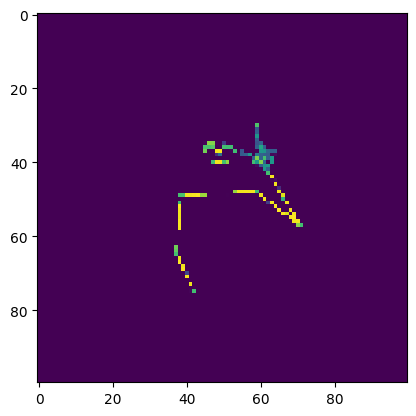

8


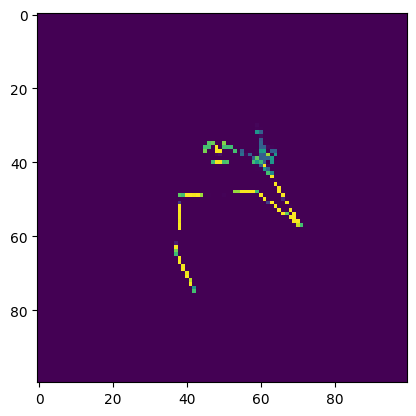

8


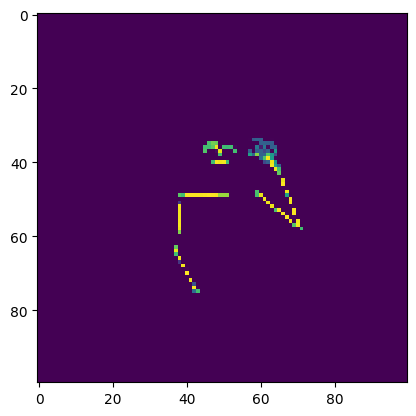

8


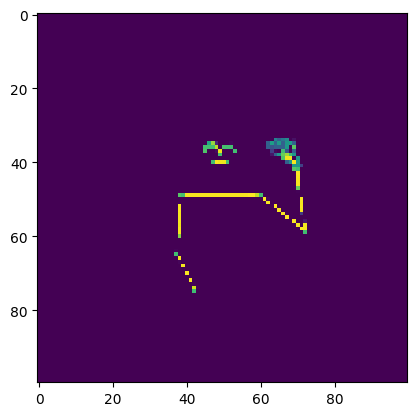

8


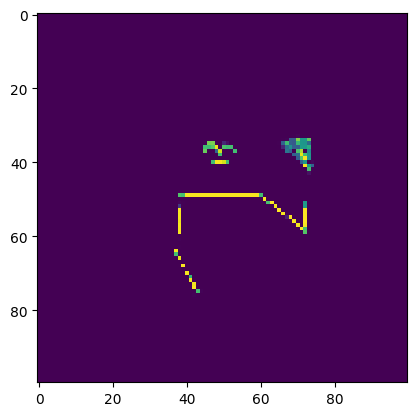

8


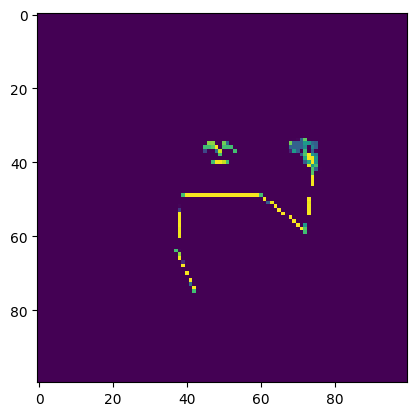

8


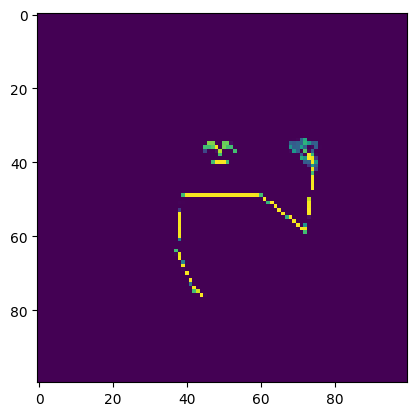

8


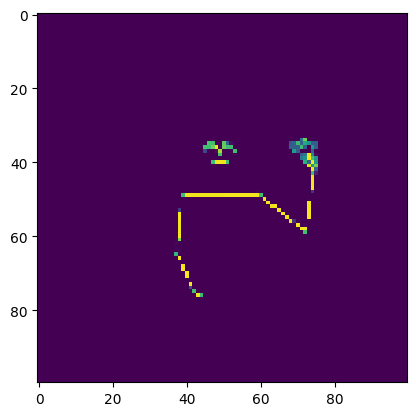

In [ ]:
from matplotlib import pyplot as plt
for i in range(len(test)):
  print(len(test))
  plt.imshow(test[i], interpolation='nearest')
  plt. grid(False)
  plt.show()

Define FrameGenerator class to create iterable object that can feed data into Tensorflow data pipeline. Output from the generator function is an array of frames and binarize vector of label.

In [7]:
HEIGHT=100
WIDTH=100
n_frames=8
frame_step=12

In [8]:
class Frame_Generator:

  def __init__(self, folderPath, class_ids, n_frames, output_size, shuffle=False):

      """ Returns a set of frames with associated label.

      Args:
        path= video file paths
        n_frames= number of frames
        training: boolean to determine if dataset is being created.
      """
      self.folderPath= folderPath
      self.class_ids= class_ids
      self.n_frames= n_frames
      self.shuffle= shuffle
      self.output_size= output_size

  def get_files_and_class_names(self):
      video_paths= []
      classes=[]
      for folder in os.listdir(self.folderPath):
        folder_path= self.folderPath+"/"+folder
        for f in os.listdir(folder_path):
          if f.endswith('mp4'):
            tag=f.split("_")[0]
            classes.append(tag)
            file_p= self.folderPath+"/"+folder+"/"+f
            video_paths.append(file_p)
      return video_paths, classes

  def __call__(self):
      video_paths, classes = self.get_files_and_class_names()

      pairs = list(zip(video_paths, classes))

      if self.shuffle:
        random.shuffle(pairs)

      for path, name in pairs:
        video_frames= frames_from_video_file(path, self.n_frames, self.output_size)
        label= self.class_ids[name]
        yield video_frames, label



In [12]:
fg = Frame_Generator(folderPath=trainPath,
                     class_ids= class_ids, n_frames=n_frames, output_size=(80, 80),shuffle=False)
frames, label= next(fg())


print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (8, 80, 80, 1)
Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15,), dtype = tf.float32))
train_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=trainPath,
                                                          class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT), shuffle=True),
                                          output_signature = output_signature)

In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)


In [14]:
# Create the validation set
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15, ), dtype = tf.float32))
val_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=valPath,
                                                        class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT),shuffle=True),
                                        output_signature = output_signature)

In [15]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 100, 100, 1)
Shape of training labels: (15,)
Shape of validation set of frames: (8, 100, 100, 1)
Shape of validation labels: (15,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [17]:
train_ds = train_ds.batch(32)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')


Shape of training set of frames: (32, 8, 100, 100, 1)
Shape of training labels: (32, 15)


In [18]:
val_ds = val_ds.batch(32)

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of validation set of frames: (32, 8, 100, 100, 1)
Shape of validation labels: (32, 15)


In [19]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15,), dtype = tf.float32))
test_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=testPath,
                                                          class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT), shuffle=True),
                                          output_signature = output_signature)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [21]:
test_ds = test_ds.batch(32)

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of validation set of frames: (32, 8, 100, 100, 1)
Shape of validation labels: (32, 15)


## **Create Model**

## 3DConv-GRU

In [22]:
import keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=5a25336ec355e0f01bf5fba8d31dd302513994660ba7ac1ca162ca80c9c5c369
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [24]:
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,GRU, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers

input_shape = (None, 8, 100, 100, 1)
input = Input(shape=(input_shape[1:]))
x = input
x = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
shape = keras.backend.int_shape(x)
x= layers.Reshape((shape[1],shape[-3]*shape[-2]*shape[-1]))(x)
x = layers.GRU(4, return_sequences=True)(x)
x = SeqSelfAttention(attention_width=15,attention_activation='sigmoid',
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Flatten()(x)
x = layers.Dense(15, activation='softmax')(x)

model = keras.Model(input, x)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 100, 100, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 8, 100, 100, 32)   896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 32)    0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 8, 50, 50, 32)     0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 64)     55360     
                                                             

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=0.8)

def lrSchedule(epoch):
    lr  = 0.001
    if epoch > 10:
        lr  *= 0.0001

    print('Learning rate: ', lr)
    return lr
LRScheduler     = LearningRateScheduler(lrSchedule)

In [27]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [28]:
gru_result = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    use_multiprocessing=True,
                    workers=20,
                    callbacks=[callback])

Epoch 1/20
120/120 [==============================] - 4495s 29s/step - loss: 2.2960 - accuracy: 0.2299 - val_loss: 1.9866 - val_accuracy: 0.2979
Epoch 2/20
120/120 [==============================] - 1702s 14s/step - loss: 1.5209 - accuracy: 0.4547 - val_loss: 1.6092 - val_accuracy: 0.4531
Epoch 3/20
120/120 [==============================] - 1657s 14s/step - loss: 1.1654 - accuracy: 0.5854 - val_loss: 1.4623 - val_accuracy: 0.5031
Epoch 4/20
120/120 [==============================] - 1676s 14s/step - loss: 0.9639 - accuracy: 0.6690 - val_loss: 1.3965 - val_accuracy: 0.5625
Epoch 5/20
120/120 [==============================] - 1669s 14s/step - loss: 0.8067 - accuracy: 0.7464 - val_loss: 1.3199 - val_accuracy: 0.6010
Epoch 6/20
120/120 [==============================] - 1721s 14s/step - loss: 0.6989 - accuracy: 0.7794 - val_loss: 1.2558 - val_accuracy: 0.6208
Epoch 7/20
120/120 [==============================] - 1884s 16s/step - loss: 0.5745 - accuracy: 0.8492 - val_loss: 1.2766 - val_ac

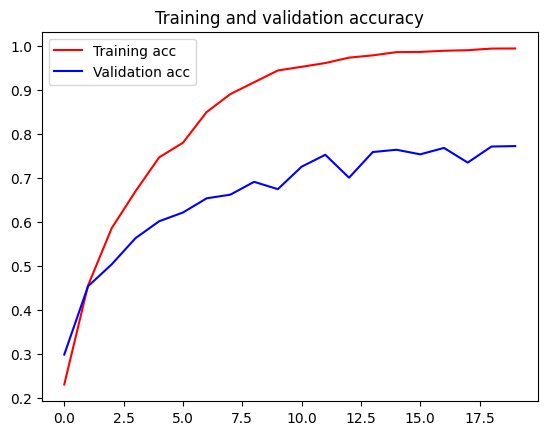

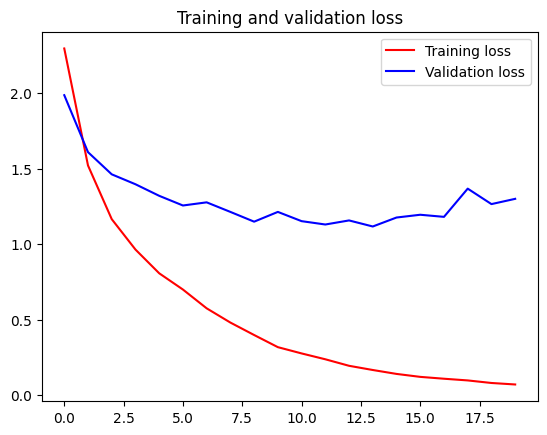

In [29]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = gru_result .history['accuracy']
val_acc = gru_result .history['val_accuracy']
loss = gru_result .history['loss']
val_loss = gru_result .history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Capstone /lsa/gru.h5')

In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15,), dtype = tf.float32))
test_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=testPath,
                                                          class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT), shuffle=True),
                                          output_signature = output_signature)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
test_ds = test_ds.batch(32)

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of validation set of frames: (32, 8, 100, 100, 1)
Shape of validation labels: (32, 15)


In [ ]:
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,GRU, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers


In [30]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)

5/5 [==============================] - 171s 34s/step - loss: 0.2995 - accuracy: 0.9267


In [ ]:
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [31]:
true_labels = np.argmax(test_labels, axis=1)
true_labels

array([ 5,  0, 11,  3,  6, 11,  8, 11,  3,  8,  3,  1,  3,  9,  4,  2,  2,
        8,  5,  3, 13, 12, 12, 10,  0,  9, 13,  5, 12,  1, 14,  1])

In [32]:
#confusion matrix
# Make predictions on the test data
predictions = model.predict(test_frames)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 [==============================] - 1s 698ms/step


array([ 5,  0, 13,  3,  6, 11,  8, 11,  3,  8,  3,  1,  3,  9,  4,  2,  5,
        8,  5,  3, 13, 12, 12, 10,  0,  9, 13,  5, 12,  1,  7,  1])

In [33]:
from sklearn.metrics import confusion_matrix

# from sklearn.metrics import confusion_matrix
confusion_lstm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_lstm)

Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


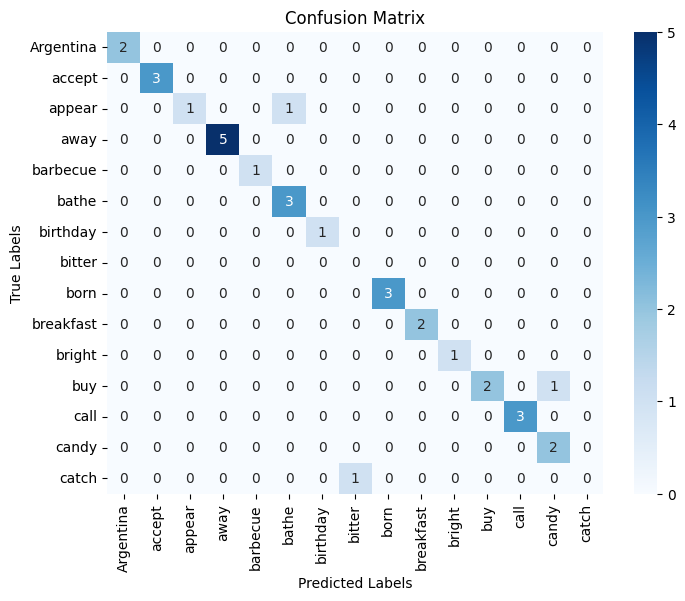

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_lstm, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

   Argentina       1.00      1.00      1.00         2
      accept       1.00      1.00      1.00         3
      appear       1.00      0.50      0.67         2
        away       1.00      1.00      1.00         5
    barbecue       1.00      1.00      1.00         1
       bathe       0.75      1.00      0.86         3
    birthday       1.00      1.00      1.00         1
      bitter       0.00      0.00      0.00         0
        born       1.00      1.00      1.00         3
   breakfast       1.00      1.00      1.00         2
      bright       1.00      1.00      1.00         1
         buy       1.00      0.67      0.80         3
        call       1.00      1.00      1.00         3
       candy       0.67      1.00      0.80         2
       catch       0.00      0.00      0.00         1

    accuracy                           0.91        32
   macro avg       0.83      0.81      0.81        32
weighted avg       0.92   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

### 3DConv-LSTM

In [ ]:
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,LSTM, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers

from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,GRU, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers

input_shape = (None, 8, 100, 100, 1)
input = Input(shape=(input_shape[1:]))
x = input
x = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
shape = keras.backend.int_shape(x)
x= layers.Reshape((shape[1],shape[-3]*shape[-2]*shape[-1]))(x)
x = layers.LSTM(4, return_sequences=True)(x)
x = SeqSelfAttention(attention_width=15,attention_activation='sigmoid',
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Flatten()(x)
x = layers.Dense(15, activation='softmax')(x)

model = keras.Model(input, x)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8, 100, 100, 1)]  0         
                                                                 
 conv3d_10 (Conv3D)          (None, 8, 100, 100, 32)   896       
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 8, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 re_lu_9 (ReLU)              (None, 8, 50, 50, 32)     0         
                                                                 
 dropout_11 (Dropout)        (None, 8, 50, 50, 32)     0         
                                                                 
 conv3d_11 (Conv3D)          (None, 8, 50, 50, 64)     55360     
                                                           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=0.9)

def lrSchedule(epoch):
    lr  = 0.001
    if epoch > 10:
        lr  = 0.0001

    print('Learning rate: ', lr)
    return lr
LRScheduler= LearningRateScheduler(lrSchedule)

In [ ]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [ ]:
lstm_result = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[callback])

Epoch 1/20
120/120 [==============================] - 1223s 10s/step - loss: 2.3783 - accuracy: 0.1906 - val_loss: 2.0281 - val_accuracy: 0.3271
Epoch 2/20
120/120 [==============================] - 1227s 10s/step - loss: 1.7054 - accuracy: 0.3737 - val_loss: 1.6845 - val_accuracy: 0.3948
Epoch 3/20
120/120 [==============================] - 1228s 10s/step - loss: 1.3615 - accuracy: 0.4914 - val_loss: 1.5652 - val_accuracy: 0.4698
Epoch 4/20
120/120 [==============================] - 1227s 10s/step - loss: 1.0877 - accuracy: 0.6198 - val_loss: 1.2832 - val_accuracy: 0.5406
Epoch 5/20
120/120 [==============================] - 1227s 10s/step - loss: 0.9264 - accuracy: 0.6716 - val_loss: 1.1880 - val_accuracy: 0.5656
Epoch 6/20
120/120 [==============================] - 1227s 10s/step - loss: 0.7796 - accuracy: 0.7292 - val_loss: 1.1747 - val_accuracy: 0.6062
Epoch 7/20
120/120 [==============================] - 1227s 10s/step - loss: 0.6652 - accuracy: 0.7807 - val_loss: 1.1280 - val_ac

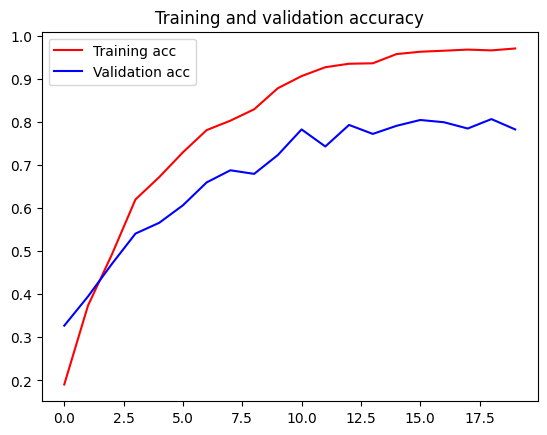

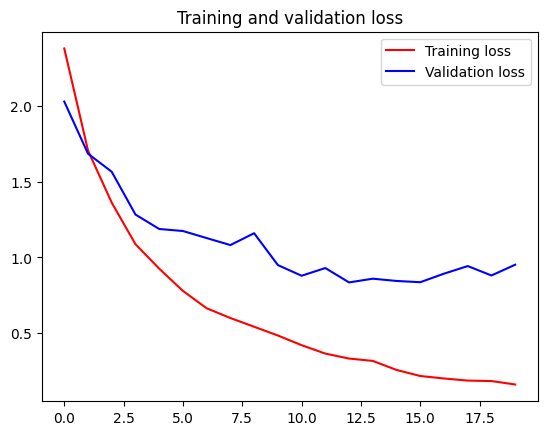

In [ ]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = lstm_result .history['accuracy']
val_acc = lstm_result .history['val_accuracy']
loss = lstm_result .history['loss']
val_loss = lstm_result .history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)

5/5 [==============================] - 139s 26s/step - loss: 0.4753 - accuracy: 0.8600


In [ ]:
true_labels = np.argmax(test_labels, axis=1)
true_labels

array([ 2, 11, 14, 10, 12,  1, 14,  7, 13,  3, 12,  9,  7,  0,  4,  1,  8,
       11,  8,  9,  0, 12,  6,  8,  6,  5,  1,  2,  3, 14,  0,  7])

In [ ]:
#confusion matrix
# Make predictions on the test data
predictions = model.predict(test_frames)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 [==============================] - 1s 772ms/step


array([ 2, 11, 14, 10, 12,  1, 14,  7, 13,  3, 12,  9,  7,  0,  4,  1,  8,
       11,  8,  5,  0, 12, 13, 12,  6,  5,  1,  2,  3, 14,  0,  7])

In [ ]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix
confusion_lstm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_lstm)

Confusion Matrix:
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


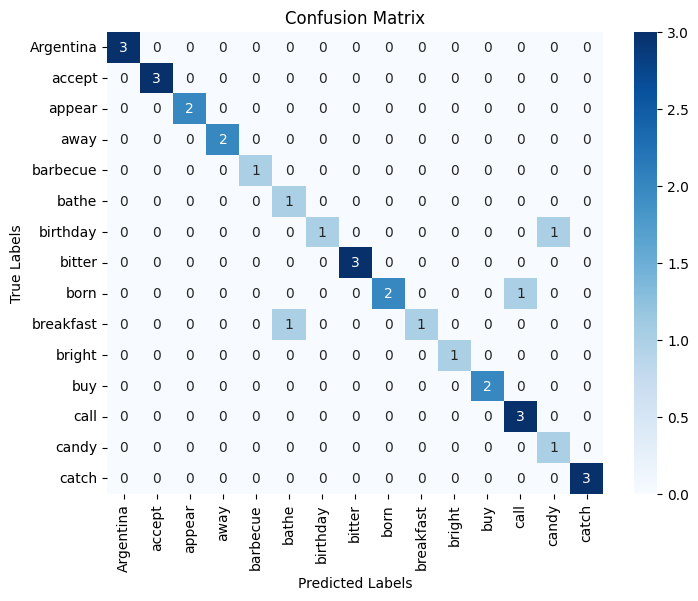

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_lstm, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

   Argentina       1.00      1.00      1.00         3
      accept       1.00      1.00      1.00         3
      appear       1.00      1.00      1.00         2
        away       1.00      1.00      1.00         2
    barbecue       1.00      1.00      1.00         1
       bathe       0.50      1.00      0.67         1
    birthday       1.00      0.50      0.67         2
      bitter       1.00      1.00      1.00         3
        born       1.00      0.67      0.80         3
   breakfast       1.00      0.50      0.67         2
      bright       1.00      1.00      1.00         1
         buy       1.00      1.00      1.00         2
        call       0.75      1.00      0.86         3
       candy       0.50      1.00      0.67         1
       catch       1.00      1.00      1.00         3

    accuracy                           0.91        32
   macro avg       0.92      0.91      0.89        32
weighted avg       0.95   